In [17]:
import os
import pickle
import random
import glob
import datetime
import pandas as pd
import numpy as np
import cv2
import pydicom
from tqdm import tqdm
from joblib import delayed, Parallel
import zipfile
from pydicom.filebase import DicomBytesIO
import sys
from PIL import Image


import click
from joblib import delayed, Parallel
import random
from PIL import Image
from scipy import ndimage
from skimage import exposure




# 1

In [105]:
def get_dicom_value(x, cast=int):
    if type(x) in [pydicom.multival.MultiValue, tuple]:
        return cast(x[0])
    else:
        return cast(x)


def cast(value):
    if type(value) is pydicom.valuerep.MultiValue:
        return tuple(value)
    return value


def get_dicom_raw(dicom):
    return {attr:cast(getattr(dicom,attr)) for attr in dir(dicom) if attr[0].isupper() and attr not in ['PixelData']}


def rescale_image(image, slope, intercept):
    return image * slope + intercept


def apply_window(image, center, width):
    image = image.copy()
    min_value = center - width // 2
    max_value = center + width // 2
    image[image < min_value] = min_value
    image[image > max_value] = max_value
    return image




def apply_window_policy(image):

    image1 = apply_window(image, 40, 80) # brain
    image2 = apply_window(image, 80, 200) # subdural
    image3 = apply_window(image, 40, 380) # bone
    image1 = (image1 - 0) / 80
    image2 = (image2 - (-20)) / 200
    image3 = (image3 - (-150)) / 380
    image = np.array([
        image1 - image1.mean(),
        image2 - image2.mean(),
        image3 - image3.mean(),
    ]).transpose(1,2,0)
    return image

def convert_dicom_to_jpg(name):
    try:
        
        dicom = pydicom.dcmread(name)
        image = dicom.pixel_array
        image = rescale_image(image, dicom.RescaleSlope, dicom.RescaleIntercept)
        image = apply_window_policy(image)
        image -= image.min((0,1))
        image = (255*image).astype(np.uint8)
        if crop:
            x_min, x_max, y_min, y_max = crop_head.crop_extents(image > 0)
            image = image[x_min:x_max, y_min:y_max]

        if image.shape[0] == 0 or image.shape[1] == 0:
            image = np.zeros(shape=(512, 512, 3), dtype=np.uint8)

        return image
    except ValueError as e:
        print("ValueError with", dicom.SOPInstanceUID, e)

        


# 2

In [51]:
class CropHead(object):
    def __init__(self, offset=10):
        """
        Crops the head by labelling the objects in an image and keeping the second largest object (the largest object
        is the background). This method removes most of the headrest

        Originally made as a image transform for use with PyTorch, but too slow to run on the fly :(
        :param offset: Pixel offset to apply to the crop so that it isn't too tight
        """
        self.offset = offset

    def crop_extents(self, img):
        try:
            if type(img) != np.array:
                img_array = np.array(img)
            else:
                img_array = img

            labeled_blobs, number_of_blobs = ndimage.label(img_array)
            blob_sizes = np.bincount(labeled_blobs.flatten())
            head_blob = labeled_blobs == np.argmax(blob_sizes[1:]) + 1  # The number of the head blob
            head_blob = np.max(head_blob, axis=-1)

            mask = head_blob == 0
            rows = np.flatnonzero((~mask).sum(axis=1))
            cols = np.flatnonzero((~mask).sum(axis=0))

            x_min = max([rows.min() - self.offset, 0])
            x_max = min([rows.max() + self.offset + 1, img_array.shape[0]])
            y_min = max([cols.min() - self.offset, 0])
            y_max = min([cols.max() + self.offset + 1, img_array.shape[1]])

            return x_min, x_max, y_min, y_max
        except ValueError:
            return 0, 0, -1, -1

    def __call__(self, img):
        """
        Crops a CT image to so that as much black area is removed as possible
        :param img: PIL image
        :return: Cropped image
        """

        x_min, x_max, y_min, y_max = self.crop_extents(img)

        try:
            if type(img) != np.array:
                img_array = np.array(img)
            else:
                img_array = img

            return Image.fromarray(np.uint8(img_array[x_min:x_max, y_min:y_max]))
        except ValueError:
            return img

    def __repr__(self):
        return self.__class__.__name__ + '(offset={})'.format(self.offset)

In [43]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def linear_windowing(img, window_width, window_length):
    """
    Applies a linear window on an array
    :param img: Image array (in Hounsfield units)
    :param window_width:
    :param window_length:
    :return:
    """
    if window_width and window_length:
        lower = window_length - (window_width / 2)
        upper = window_length + (window_width / 2)
        img = np.clip(img, lower, upper)
        img = (img - lower) / (upper - lower)
        return (img*255).astype(np.uint8)
    else:
        return img


def sigmoid_windowing(img, window_width, window_length, u=255, epsilon=255):
    """
    Applies a sigmoid window on an array
    From Practical Window Setting Optimization for Medical Image Deep Learning https://arxiv.org/pdf/1812.00572.pdf
    :param img: Image array (in Hounsfield units)
    :param window_width:
    :param window_length:
    :param u:
    :param epsilon:
    :return:
    """
    if window_width and window_length:
        weight = (2 / window_width) * np.log((u / epsilon) - 1)
        bias = (-2 * window_length / window_width) * np.log((u / epsilon) - 1)
        img = u * sigmoid(weight * img + bias)
        return img.astype(np.uint8)
    else:
        return img


In [44]:
def prepare_dicom(dcm, default_window=False):
    """
    Converts a DICOM object to a 16-bit Numpy array (in Housnfield units) or a uint8 image if the default window is used
    :param dcm: DICOM Object
    :param default_window: Flag to use the window settings specified in the metadata
    :return: Numpy array in either int16 or uint8
    """

    try:
        if dcm.BitsStored == 12 and dcm.PixelRepresentation == 0 and dcm.RescaleIntercept > -100:
            x = dcm.pixel_array + 1000
            px_mode = 4096
            x[x >= px_mode] = x[x >= px_mode] - px_mode
            dcm.PixelData = x.tobytes()
            dcm.RescaleIntercept = -1000

        pixels = dcm.pixel_array.astype(np.float32) * dcm.RescaleSlope + dcm.RescaleIntercept
    except ValueError as e:
        print("ValueError with", dcm.SOPInstanceUID, e)
        return np.zeros((512, 512))

    # Pad the image if it isn't square
    if pixels.shape[0] != pixels.shape[1]:
        (a, b) = pixels.shape
        if a > b:
            padding = ((0, 0), ((a - b) // 2, (a - b) // 2))
        else:
            padding = (((b - a) // 2, (b - a) // 2), (0, 0))
        pixels = np.pad(pixels, padding, mode='constant', constant_values=0)
        # Return image windows as per the metadata parameters
    if default_window:
        width = dcm.WindowWidth
        if type(width) != pydicom.valuerep.DSfloat:
            width = width[0]

        level = dcm.WindowCenter
        if type(level) != pydicom.valuerep.DSfloat:
            level = level[0]

        img_windowed = linear_windowing(pixels, width, level)
        return img_windowed
    # Return array Hounsfield units only
    else:
        return pixels.astype(np.int16)


In [116]:
windows = [
        (None, None),  # No windowing
        (80, 40),  # Brain
        (200, 80),  # Subdural
        (40, 40),  # Stroke
        (2800, 600),  # Temporal bone
        (380, 40),  # Soft tissue
        (2000, 600),  # Bone
    ]

crop_head = CropHead()
channels = (1,2,6)
crop =True

ds = pydicom.dcmread(TRAIN_DIR)

rgb = []
for c in channels:
    if c == 0:
        ch = prepare_dicom(ds, default_window=False)
    else:
        ch = prepare_dicom(ds)
        ch = linear_windowing(ch, windows[c][0], windows[c][1])
    rgb.append(ch)

img = np.stack(rgb, -1)

if crop:
    x_min, x_max, y_min, y_max = crop_head.crop_extents(img > 0)
    img = img[x_min:x_max, y_min:y_max]

    if img.shape[0] == 0 or img.shape[1] == 0:
        img = np.zeros(shape=(512, 512, 3), dtype=np.uint8)


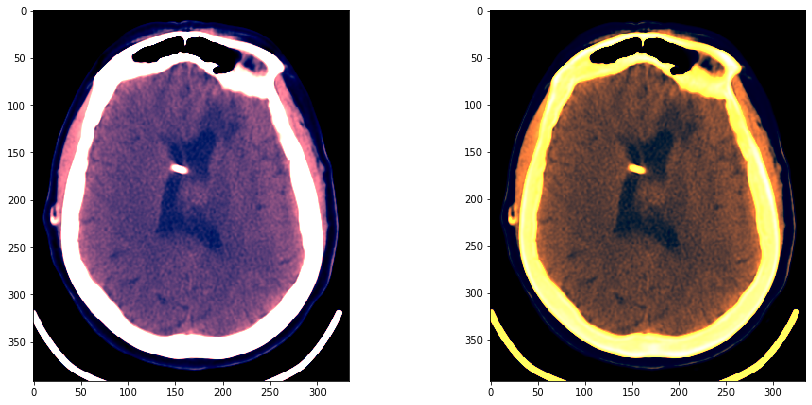

In [111]:
# importing pyplot and image from matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
TRAIN_DIR = 'C:/Users/91800/Desktop/ID_f40ac6f95.dcm'
image1 = convert_dicom_to_jpg(TRAIN_DIR)



 


fig = plt.figure(figsize=(15,15))

plt.subplot(2, 2, 1)
plt.imshow(image1,cmap=plt.cm.bone)

plt.subplot(2, 2, 2)
plt.imshow(img,cmap=plt.cm.bone)

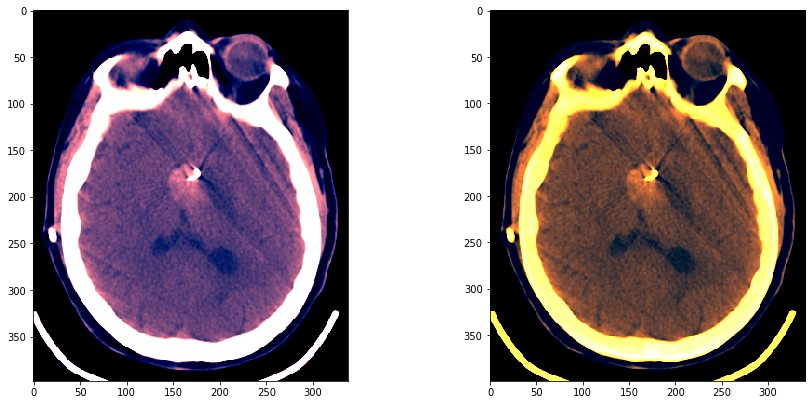

In [114]:
# importing pyplot and image from matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
TRAIN_DIR = 'C:/Users/91800/Desktop/ID_d6fef64ad.dcm'
image1 = convert_dicom_to_jpg(TRAIN_DIR)



 


fig = plt.figure(figsize=(15,15))

plt.subplot(2, 2, 1)
plt.imshow(image1,cmap=plt.cm.bone)

plt.subplot(2, 2, 2)
plt.imshow(img,cmap=plt.cm.bone)

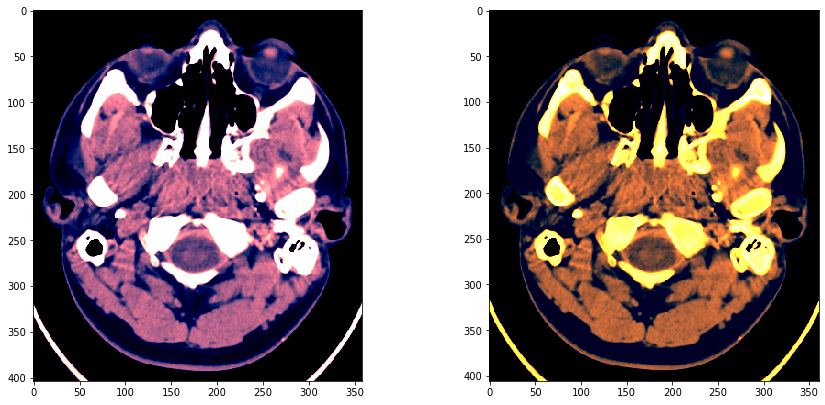

In [117]:
TRAIN_DIR = 'C:/Users/91800/Desktop/ID_f9ddf8034.dcm'
image1 = convert_dicom_to_jpg(TRAIN_DIR)


# importing pyplot and image from matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 


fig = plt.figure(figsize=(15,15))

plt.subplot(2, 2, 1)
plt.imshow(image1,cmap=plt.cm.bone)

plt.subplot(2, 2, 2)
plt.imshow(img,cmap=plt.cm.bone)

# Augmentation

In [118]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, ElasticTransform, ChannelShuffle,RGBShift, Rotate
)
import cv2

In [119]:
def augment(aug, image):
    return aug(image=image)['image']

In [120]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
TRAIN_DIR = 'C:/Users/91800/Desktop/ID_f9ddf8034.dcm'
demo_rgb = convert_dicom_to_jpg(TRAIN_DIR)

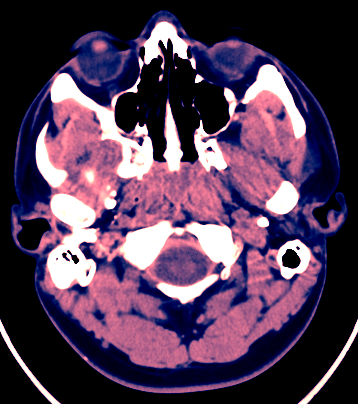

In [121]:
aug = HorizontalFlip(p=1)
Image.fromarray(augment(aug,np.array(demo_rgb)))

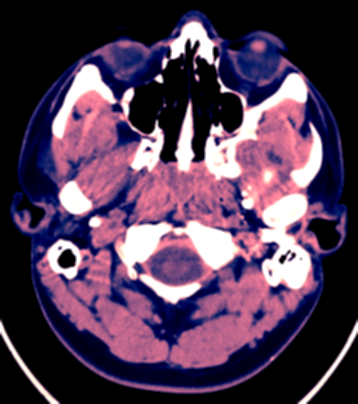

In [122]:
aug = Blur(p=1,blur_limit=3)
Image.fromarray(augment(aug,np.array(demo_rgb)))

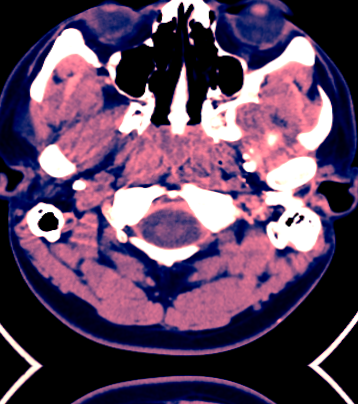

In [123]:
aug = ElasticTransform(p=1,border_mode=cv2.BORDER_REFLECT_101,alpha_affine=40)
Image.fromarray(augment(aug,np.array(demo_rgb)))


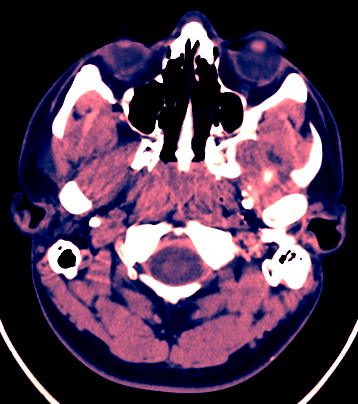

In [124]:
aug = RandomGamma(p=1)
Image.fromarray(augment(aug,np.array(demo_rgb)))


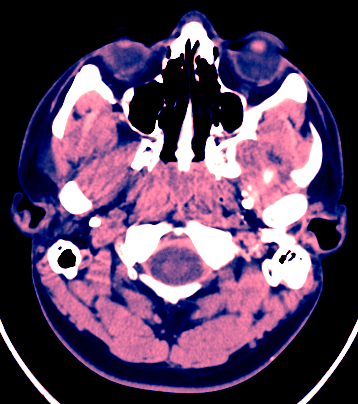

In [125]:
aug = RandomContrast(p=1)
Image.fromarray(augment(aug,np.array(demo_rgb)))

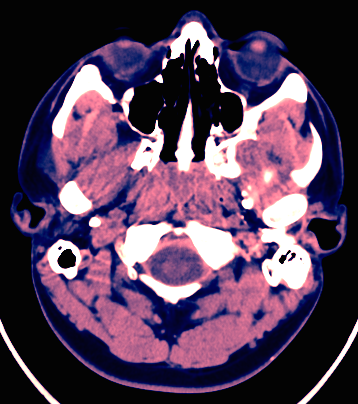

In [126]:
aug = RandomBrightness(p=1)
Image.fromarray(augment(aug,np.array(demo_rgb)))

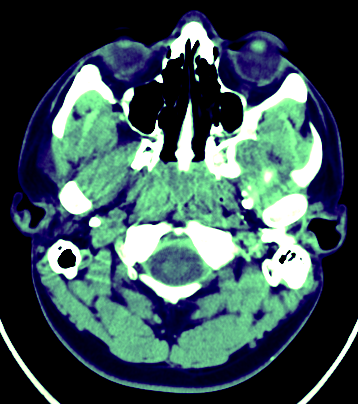

In [127]:
aug = ChannelShuffle(p=1)
Image.fromarray(augment(aug,np.array(demo_rgb)))

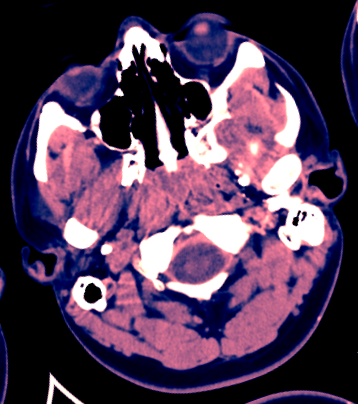

In [128]:
aug = Rotate(p=1,limit=30)
Image.fromarray(augment(aug,np.array(demo_rgb)))

In [129]:
def strong_aug(p=1):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=.1),
            Blur(blur_limit=3, p=.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        #HueSaturationValue(p=0.3),
    ], p=p)

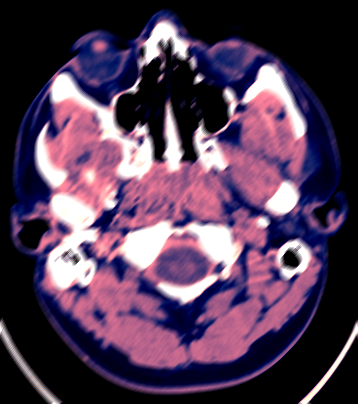

In [130]:
aug = strong_aug(p=1)
Image.fromarray(augment(aug,np.array(demo_rgb)))
